<table class="table table-bordered">
    <tr>
        <th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Deep Learning in Natural Language Processing</h1><h2>Assignment (Problem 1) - Sentiment Analysis Model </h2><h3>AY2024/25 Semester</h3></th>
    </tr>
</table>

In [1]:
import datetime
import time

In [2]:
# Import the Required Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle

# Split the X & y into train and test sets
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

## Utilities

In [6]:
def computeMaxLength(df, columnName):
    # Do this to fix the error: AttributeError: 'float' object has no attribute 'split'
    df[columnName] = df[columnName].astype(str)
    
    # Applies a lambda function to each element in the content column. 
    # The lambda function splits each text into words and calculates its length.
    # .max(): Finds the maximum length from the list of lengths produced by the apply function.
    max_length = df['content'].apply(lambda x: len(x.split())).max()
    return max_length

In [7]:
# https://www.geeksforgeeks.org/how-to-plot-value-counts-in-pandas/
def plotHistogram(df, columnName):
    # Get the value counts of the 'score' column and sort them by index
    score_counts = df[columnName].value_counts().sort_index()

    # Define colors for each bar 
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    # Plot the histogram with the default color palette
    plt.figure(figsize=(10, 6))
    bars = score_counts.plot(kind='bar', color=colors)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Histogram of Scores')

    # Add text annotations to each bar
    for bar in bars.patches:
        bars.annotate(format(bar.get_height(), '.0f'),
                      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      ha='center', va='center',
                      size=12, xytext=(0, 8),
                      textcoords='offset points')

    plt.show() 

In [8]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [9]:
def plotSmoothPerformance(history, which_model):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Smooth the curves
    smoothed_acc = smooth_curve(acc)
    smoothed_val_acc = smooth_curve(val_acc)
    smoothed_loss = smooth_curve(loss)
    smoothed_val_loss = smooth_curve(val_loss)

    # Plotting training and validation accuracy
    plt.plot(epochs, smoothed_acc, 'bo', label='Training accuracy')
    plt.plot(epochs, smoothed_val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy with smoothing' + ' - ' + which_model)
    plt.legend()

    filename_acc = datetime.datetime.now().strftime(which_model + '_' + '%d-%m-%y-%H_%M_s_train_val_accuracy.png')
    plt.savefig(filename_acc)  
    
    plt.figure()

    # Plotting training and validation loss
    plt.plot(epochs, smoothed_loss, 'bo', label='Training loss')
    plt.plot(epochs, smoothed_val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss with smoothing' + ' - ' + which_model)
    plt.legend()

    filename_loss = datetime.datetime.now().strftime(which_model + '_' + '%d-%m-%y-%H_%M_s_train_val_loss.png')
    plt.savefig(filename_loss)  
    
    plt.show()

In [10]:
def plotPerformance(history, which_model):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy' + ' - ' + which_model)
    plt.legend()
    
    filename_acc = datetime.datetime.now().strftime(which_model + '_' + '%d-%m-%y-%H_%M_train_val_accuracy.png')
    plt.savefig(filename_acc)

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss' + ' - ' + which_model)
    plt.legend()
    
    filename_loss = datetime.datetime.now().strftime(which_model + '_' + '%d-%m-%y-%H_%M_train_val_loss.png')
    plt.savefig(filename_loss)     

    plt.show() 

In [11]:
def saveTrainingistory(history, which_model):
    # Create a DataFrame from history object
    history_df = pd.DataFrame(history.history)

    # Save to CSV
    history_df.to_csv(which_model + '_' + 'training_history.csv', index=False)
    
    return history_df

## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [12]:
# Read the data from the CSV file
df = pd.read_csv('chrome_reviews_1K.csv')

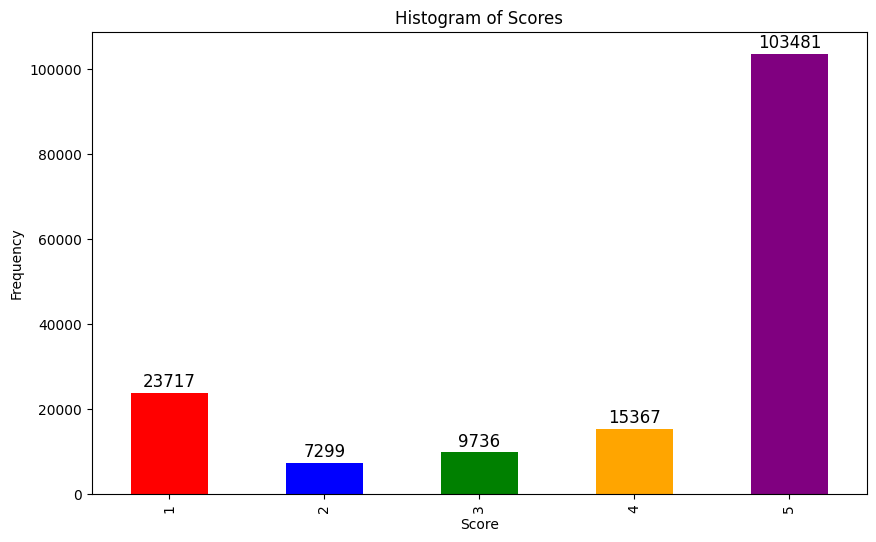

In [13]:
plotHistogram(df, 'score')

In [15]:
# Imbalanced dataset handling
# https://www.geeksforgeeks.org/imbalanced-learn-module-in-python/
from imblearn.over_sampling import RandomOverSampler

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

In [16]:
X_os_resampled, y_os_resampled = ros.fit_resample(df['content'].values.reshape(-1, 1),  df['score'])
# Create a new DataFrame with the resampled data
df_os_resampled = pd.DataFrame({'content': X_os_resampled.flatten(), 'score': y_os_resampled})

# Shuffle the resampled data
df_os_resampled = shuffle(df_os_resampled, random_state=42)

df_os_resampled.value_counts()

content                 score
Good                    5        12075
                        4        10893
                        3         7485
Nice                    5         4500
Good                    2         4022
                                 ...  
Goodnight 🌃             5            1
S,,ss,,,zs, Mumbai er,  5            1
Goodness you            5            1
Goodness to             5            1
🫶🫶🫶🫶🫶good Chrome        5            1
Length: 97416, dtype: int64

In [17]:
# plotHistogram(df_os_resampled, 'score')
df_os_resampled['score'].value_counts()

2    103481
5    103481
1    103481
4    103481
3    103481
Name: score, dtype: int64

In [18]:
# .values - This converts the 'content' column into a NumPy array.
# This variable, texts, now holds the array of text strings from the 'content' column.
texts_os = df_os_resampled['content'].values
labels_os = df_os_resampled['score'].values
max_length = computeMaxLength(df_os_resampled, 'content')

In [19]:
len(texts_os)

517405

In [20]:
print (df_os_resampled.dtypes)

content    object
score       int64
dtype: object


In [ ]:
# texts = df['content'].str.replace(r'[^\w\s]','', regex=True).values
# Do this to fix the error: AttributeError: 'float' object has no attribute 'split'
df['content'] = df['content'].astype(str)
texts = df['content'].values

### 1.2 Data Processing


In [ ]:
# Check the maximum length of texts
max_len = -1
for example in texts:
#     print (example.split())
    if len(example.split()) > max_len:
        max_len = len(example.split())
        
print('the maximum length of the text inputs is ', max_len)

In [21]:
max_length = computeMaxLength(df_os_resampled, 'content')
print (max_length)

153


In [22]:
max_words = 10000  # We will only consider the top 10,000 words in the dataset

def convert2NumericTensors(texts, labels, max_length, max_features=max_words):
    # This creates an instance of the Tokenizer class. The parameter, num_words, specifies
    # the maximum number of words to keep based on word frequency. 
    # Only the max_words most frequent words in the dataset will be considered.
    tokenizer = Tokenizer(num_words=max_features) # num_words: the maximum number of words to keep, based on word frequency.

    # fit_on_texts updates the internal vocabulary of the tokenizer based on the list of texts provided.
    # The parameter, texts, is an array of texts that the tokenizer will analyze. It builds a word index based 
    # on the frequency of words in these texts.
    tokenizer.fit_on_texts(texts)

    # This method converts each text in the list texts into a sequence of integers. 
    # Each integer represents the index of a word in the tokenizer's word index.
    # This variable now holds a list of lists, where each inner list contains the sequence 
    # of integer indices corresponding to the words in the original text.
    sequences = tokenizer.texts_to_sequences(texts)
    # print (sequences)

    # Number of unique tokens
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    # It is used to ensure that all sequences in a list have the same length by padding shorter sequences 
    # with zeros (or another specified value) and truncating longer sequences if necessary.
    X = pad_sequences(sequences, maxlen=max_length)

    # Subtracts 1 from each label. If labels is an array like [1, 2, 3], it becomes [0, 1, 2].
    # Converts the adjusted labels into a one-hot encoded format.
    y = to_categorical(labels-1)

    print('Shape of text tensor:', X.shape)
    print('Shape of label tensor:', y.shape)
    
    return X, y, tokenizer

### 1.3 Data Sampling

In [23]:
X, y, tokenizer = convert2NumericTensors(texts_os, labels_os, max_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Found 78758 unique tokens.
Shape of text tensor: (517405, 153)
Shape of label tensor: (517405, 5)


## Step 2 – Develop a Sentiment Analysis Model

In [ ]:
print (len(tokenizer.word_index))
print (X_train.shape)
print (y_train.shape)
print (X.shape[1])

In [ ]:
print (tokenizer.word_index)

In [ ]:
print (X_train)

### Model #1 - Train word embedding using provided dataset

In [24]:
def getModel_1(tokenizer, embedding_dim, max_length):
    model = Sequential()
    # model1.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X.shape[1]))
    # model_1.add(Input(shape=(max_length,)))

    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length))
    # model_1.add(Embedding(max_words, embedding_dim, input_length=max_length))
    
    model.add(Dense(32, activation='relu'))
    # We flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 8)`
    model.add(Flatten())
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [25]:
# Build the Model
embedding_dim = 128

model_1a = getModel_1(tokenizer, embedding_dim, max_length)
model_1a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 153, 128)          10081152  
                                                                 
 dense (Dense)               (None, 153, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 4896)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 24485     
                                                                 
Total params: 10,109,765
Trainable params: 10,109,765
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Train the model with validation split
history_1a = model_1a.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2)

Epoch 1/40
10349/10349 [==============================] - 75s 7ms/step - loss: 1.3723 - acc: 0.4152 - val_loss: 1.2723 - val_acc: 0.4733
Epoch 2/40
10349/10349 [==============================] - 74s 7ms/step - loss: 1.2112 - acc: 0.4973 - val_loss: 1.1998 - val_acc: 0.5032
Epoch 3/40
10349/10349 [==============================] - 75s 7ms/step - loss: 1.1498 - acc: 0.5227 - val_loss: 1.1662 - val_acc: 0.5187
Epoch 4/40
10349/10349 [==============================] - 76s 7ms/step - loss: 1.1219 - acc: 0.5336 - val_loss: 1.1625 - val_acc: 0.5222
Epoch 5/40
10349/10349 [==============================] - 76s 7ms/step - loss: 1.1079 - acc: 0.5395 - val_loss: 1.1515 - val_acc: 0.5280
Epoch 6/40
10349/10349 [==============================] - 76s 7ms/step - loss: 1.1006 - acc: 0.5437 - val_loss: 1.1482 - val_acc: 0.5285
Epoch 7/40
10349/10349 [==============================] - 77s 7ms/step - loss: 1.0963 - acc: 0.5450 - val_loss: 1.1565 - val_acc: 0.5268
Epoch 8/40
10349/10349 [=================

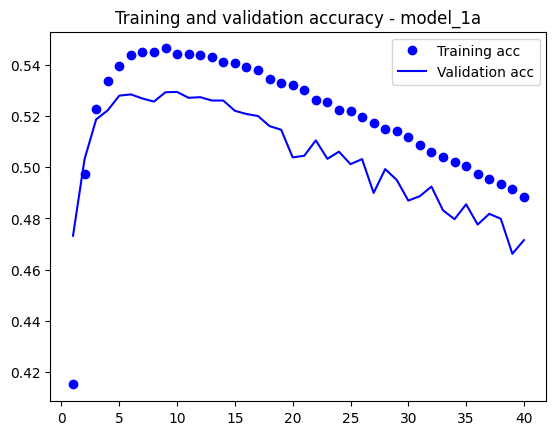

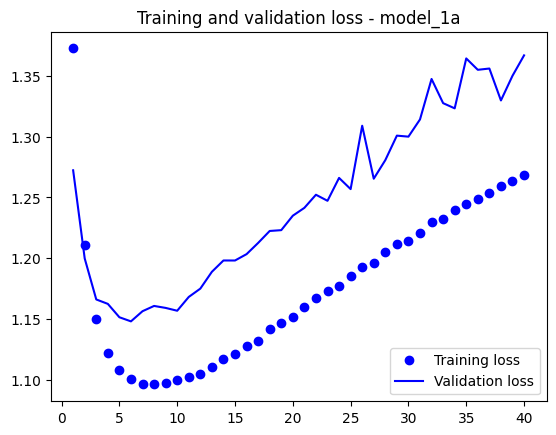

In [27]:
# Plot the Training and Validation Accuracy & Loss Scores
plotPerformance(history_1a, 'model_1a')

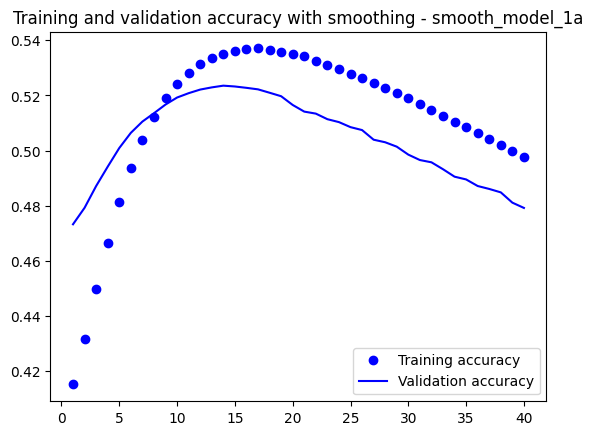

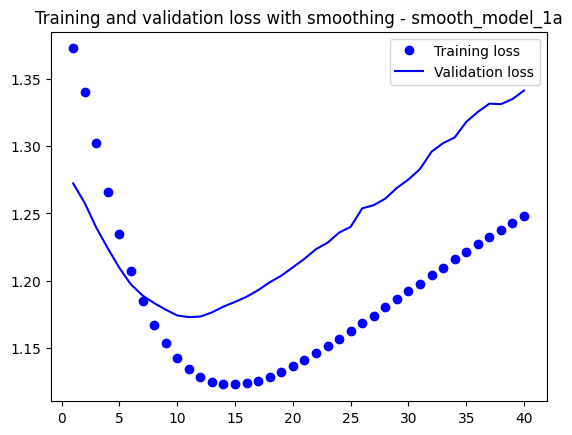

In [28]:
plotSmoothPerformance(history_1a, 'smooth_model_1a')

In [ ]:
saveTrainingistory(history_1a, 'model_1a')

In [29]:
# Save the Model
model_1a.save('text_model_1a.h5')

### Model #2 - 1D Conv Layer for Sentiment Analysis, embedding dimension = 128, - # Epochs = 25

In [30]:
def getModel_2(tokenizer, embedding_dim, max_length, dropout):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length))
    # model.add(Embedding(max_features, embedding_dim, input_length=max_length))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    
    if dropout > 0:
        model.add(Dropout(dropout))
        
    model.add(Dense(32, activation='relu'))
    if dropout > 0:
        model.add(Dropout(dropout))
        
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [31]:
model_2a = getModel_2(tokenizer, embedding_dim, max_length, -1)
model_2a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 153, 128)          10081152  
                                                                 
 conv1d (Conv1D)             (None, 149, 128)          82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 10,167,493
Trainable params: 10,167,493
Non-trainable params: 0
__________________________________________

In [32]:
history_2a = model_2a.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
10349/10349 [==============================] - 94s 9ms/step - loss: 1.2597 - acc: 0.4667 - val_loss: 1.0659 - val_acc: 0.5512
Epoch 2/25
10349/10349 [==============================] - 99s 10ms/step - loss: 0.9712 - acc: 0.5945 - val_loss: 0.9657 - val_acc: 0.5974
Epoch 3/25
10349/10349 [==============================] - 97s 9ms/step - loss: 0.8809 - acc: 0.6296 - val_loss: 0.8988 - val_acc: 0.6243
Epoch 4/25
10349/10349 [==============================] - 99s 10ms/step - loss: 0.8361 - acc: 0.6476 - val_loss: 0.8866 - val_acc: 0.6369
Epoch 5/25
10349/10349 [==============================] - 99s 10ms/step - loss: 0.8116 - acc: 0.6585 - val_loss: 0.8957 - val_acc: 0.6398
Epoch 6/25
10349/10349 [==============================] - 99s 10ms/step - loss: 0.7961 - acc: 0.6651 - val_loss: 0.8704 - val_acc: 0.6490
Epoch 7/25
10349/10349 [==============================] - 98s 10ms/step - loss: 0.7850 - acc: 0.6699 - val_loss: 0.8661 - val_acc: 0.6509
Epoch 8/25
10349/10349 [============

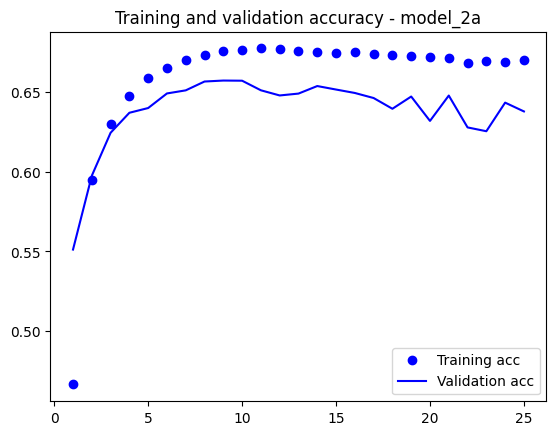

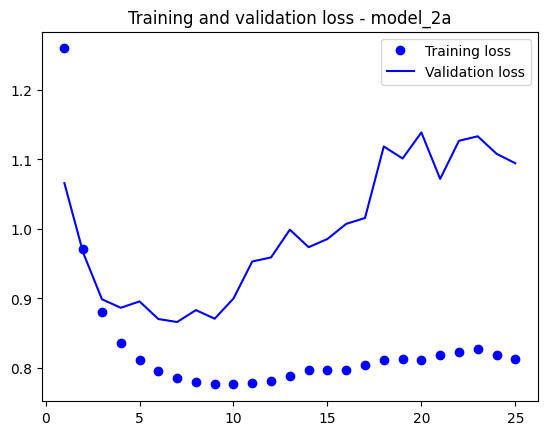

In [33]:
# Plot the Training and Validation Accuracy & Loss Scores
plotPerformance(history_2a, "model_2a")

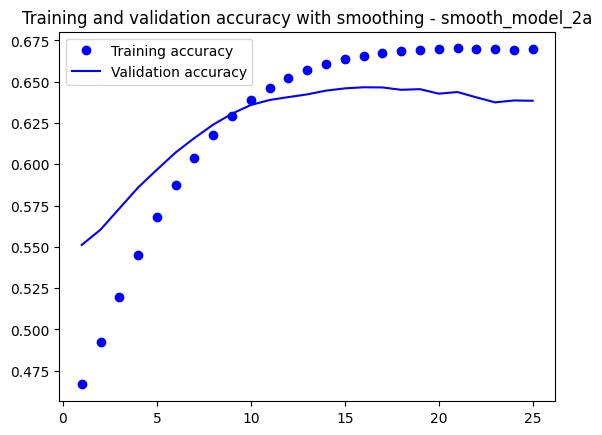

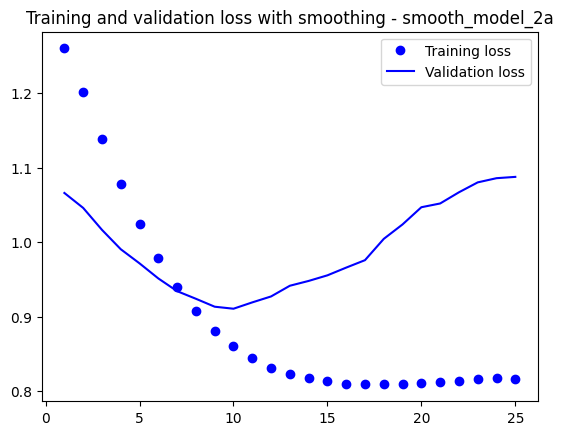

In [34]:
plotSmoothPerformance(history_2a, "smooth_model_2a")

In [35]:
# Save the Model
model_2a.save('text_model_2a_conv1D.h5')

### Model #2 - 1D Conv Layer for Sentiment Analysis, embedding dimension = 256, - # Epochs = 10

In [36]:
embedding_dim = 256
model_2b = getModel_2(tokenizer, embedding_dim, max_length, -1)
model_2b.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 153, 256)          20162304  
                                                                 
 conv1d_1 (Conv1D)           (None, 149, 128)          163968    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 20,330,565
Trainable params: 20,330,565
Non-trainable params: 0
__________________________________________

In [37]:
history_2b = model_2b.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
10349/10349 [==============================] - 123s 12ms/step - loss: 1.2215 - acc: 0.4857 - val_loss: 1.0481 - val_acc: 0.5619
Epoch 2/10
10349/10349 [==============================] - 129s 12ms/step - loss: 0.9384 - acc: 0.6089 - val_loss: 0.9210 - val_acc: 0.6144
Epoch 3/10
10349/10349 [==============================] - 128s 12ms/step - loss: 0.8568 - acc: 0.6403 - val_loss: 0.8964 - val_acc: 0.6316
Epoch 4/10
10349/10349 [==============================] - 134s 13ms/step - loss: 0.8196 - acc: 0.6561 - val_loss: 0.8676 - val_acc: 0.6429
Epoch 5/10
10349/10349 [==============================] - 130s 13ms/step - loss: 0.7994 - acc: 0.6650 - val_loss: 0.8463 - val_acc: 0.6499
Epoch 6/10
10349/10349 [==============================] - 130s 13ms/step - loss: 0.7861 - acc: 0.6709 - val_loss: 0.8744 - val_acc: 0.6503
Epoch 7/10
10349/10349 [==============================] - 132s 13ms/step - loss: 0.7844 - acc: 0.6727 - val_loss: 0.9127 - val_acc: 0.6493
Epoch 8/10
10349/10349 [===

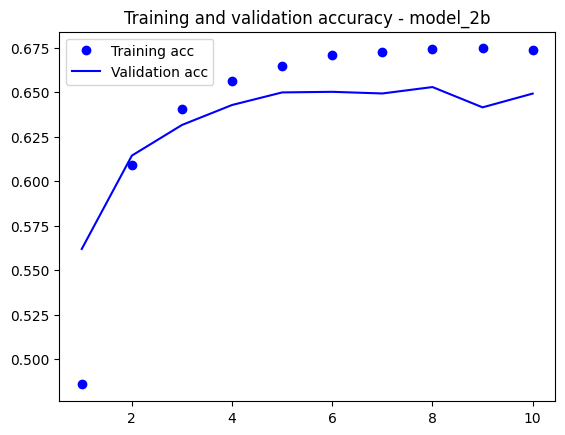

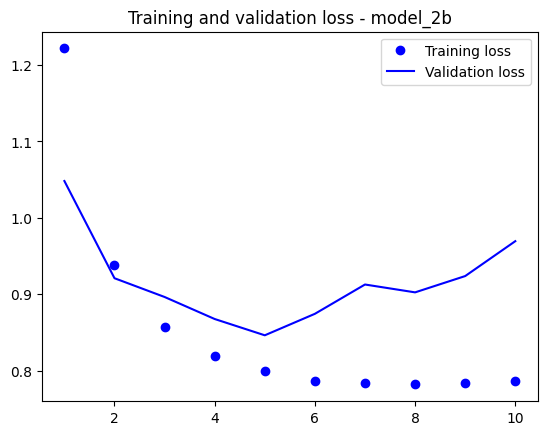

In [38]:
# Plot the Training and Validation Accuracy & Loss Scores
plotPerformance(history_2b, 'model_2b')

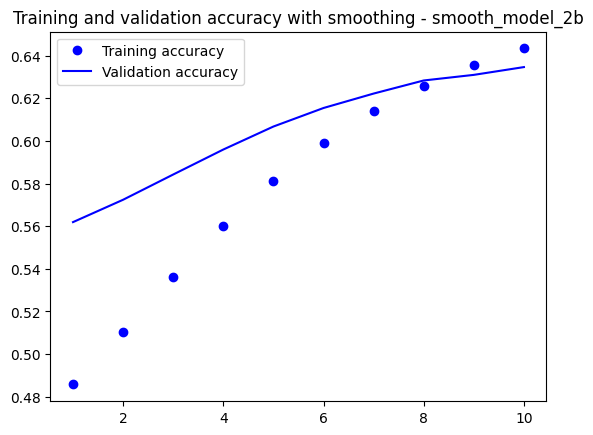

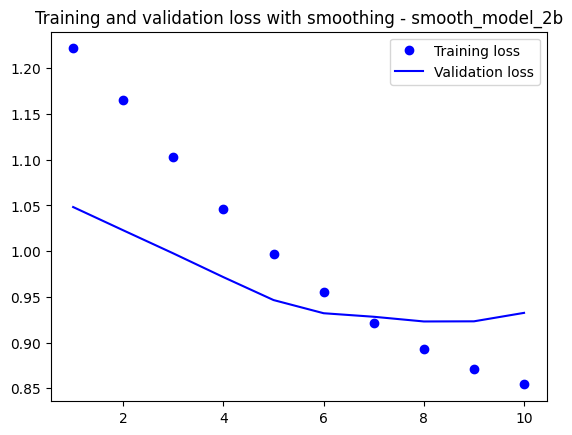

In [39]:
plotSmoothPerformance(history_2b, "smooth_model_2b")

In [40]:
# Save the Model
model_2b.save('text_model_2b_conv1D.h5')

### Model #2 - 1D Conv Layer for Sentiment Analysis, embedding dimension = 64, - # Epochs = 10

In [41]:
embedding_dim = 64
model_2c = getModel_2(tokenizer, embedding_dim, max_length, -1)
model_2c.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 153, 64)           5040576   
                                                                 
 conv1d_2 (Conv1D)           (None, 149, 128)          41088     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                                                                 
Total params: 5,085,957
Trainable params: 5,085,957
Non-trainable params: 0
____________________________________________

In [42]:
history_2c = model_2c.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
10349/10349 [==============================] - 90s 9ms/step - loss: 1.2951 - acc: 0.4504 - val_loss: 1.1185 - val_acc: 0.5390
Epoch 2/10
10349/10349 [==============================] - 88s 9ms/step - loss: 1.0176 - acc: 0.5769 - val_loss: 0.9879 - val_acc: 0.5922
Epoch 3/10
10349/10349 [==============================] - 88s 9ms/step - loss: 0.9176 - acc: 0.6160 - val_loss: 0.9387 - val_acc: 0.6118
Epoch 4/10
10349/10349 [==============================] - 88s 9ms/step - loss: 0.8699 - acc: 0.6348 - val_loss: 0.9178 - val_acc: 0.6236
Epoch 5/10
10349/10349 [==============================] - 88s 8ms/step - loss: 0.8409 - acc: 0.6459 - val_loss: 0.9316 - val_acc: 0.6109
Epoch 6/10
10349/10349 [==============================] - 88s 8ms/step - loss: 0.8217 - acc: 0.6538 - val_loss: 0.8703 - val_acc: 0.6411
Epoch 7/10
10349/10349 [==============================] - 87s 8ms/step - loss: 0.8084 - acc: 0.6595 - val_loss: 0.8736 - val_acc: 0.6450
Epoch 8/10
10349/10349 [=================

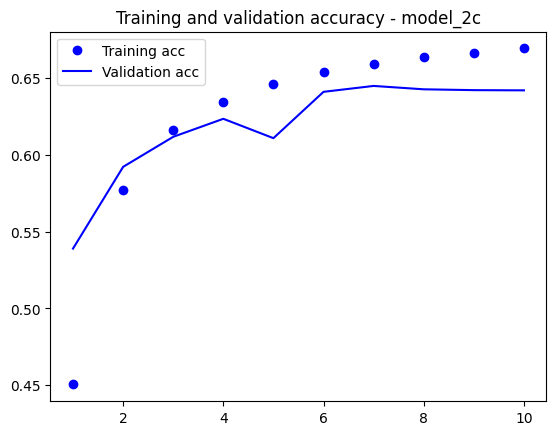

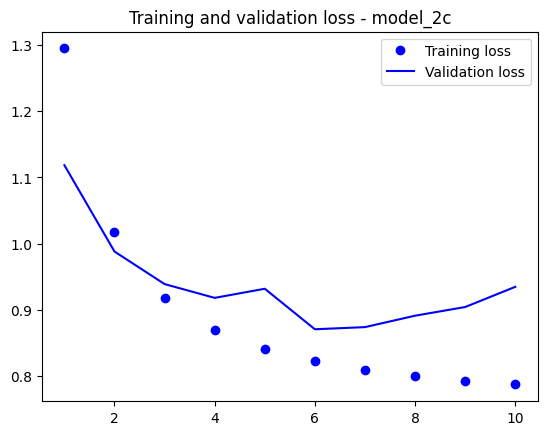

In [43]:
# Plot the Training and Validation Accuracy & Loss Scores
plotPerformance(history_2c, 'model_2c')

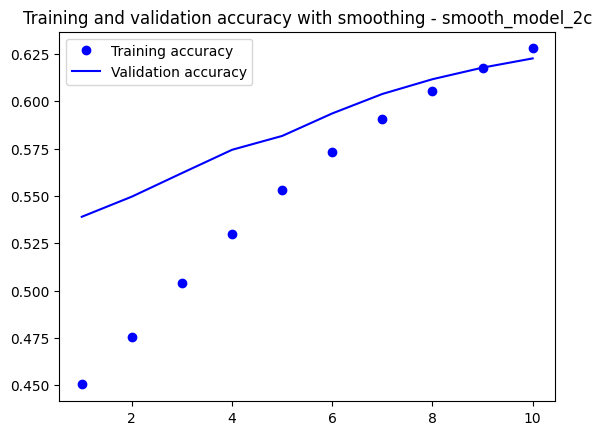

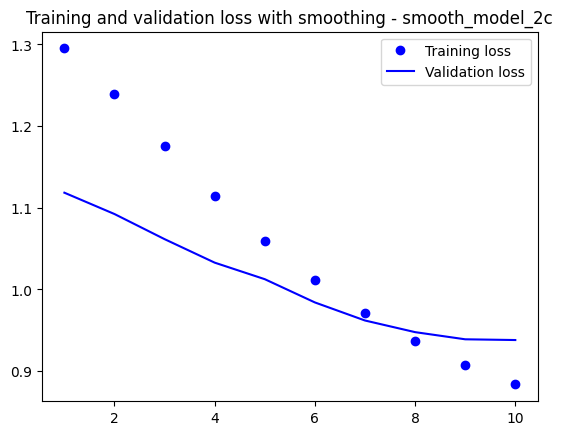

In [44]:
plotSmoothPerformance(history_2c, "smooth_model_2c")

In [45]:
# Save the Model
model_2c.save('text_model_2c_conv1D.h5')

### Model #2 - 1D Conv Layer for Sentiment Analysis, Embedding dimension = 256, Dropout = 0.3, # Epochs = 10

In [46]:
embedding_dim = 256
model_2d = getModel_2(tokenizer, embedding_dim, max_length, 0.3)
model_2d.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 153, 256)          20162304  
                                                                 
 conv1d_3 (Conv1D)           (None, 149, 128)          163968    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                      

In [47]:
# Train the Model
history_2d = model_2d.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
10349/10349 [==============================] - 129s 12ms/step - loss: 1.3823 - acc: 0.4062 - val_loss: 1.2080 - val_acc: 0.4937
Epoch 2/10
10349/10349 [==============================] - 132s 13ms/step - loss: 1.1907 - acc: 0.5081 - val_loss: 1.0752 - val_acc: 0.5532
Epoch 3/10
10349/10349 [==============================] - 133s 13ms/step - loss: 1.1008 - acc: 0.5481 - val_loss: 1.0152 - val_acc: 0.5748
Epoch 4/10
10349/10349 [==============================] - 135s 13ms/step - loss: 1.0576 - acc: 0.5681 - val_loss: 0.9842 - val_acc: 0.5891
Epoch 5/10
10349/10349 [==============================] - 131s 13ms/step - loss: 1.0306 - acc: 0.5800 - val_loss: 0.9561 - val_acc: 0.6012
Epoch 6/10
10349/10349 [==============================] - 134s 13ms/step - loss: 1.0111 - acc: 0.5877 - val_loss: 0.9430 - val_acc: 0.6096
Epoch 7/10
10349/10349 [==============================] - 128s 12ms/step - loss: 0.9947 - acc: 0.5946 - val_loss: 0.9369 - val_acc: 0.6122
Epoch 8/10
10349/10349 [===

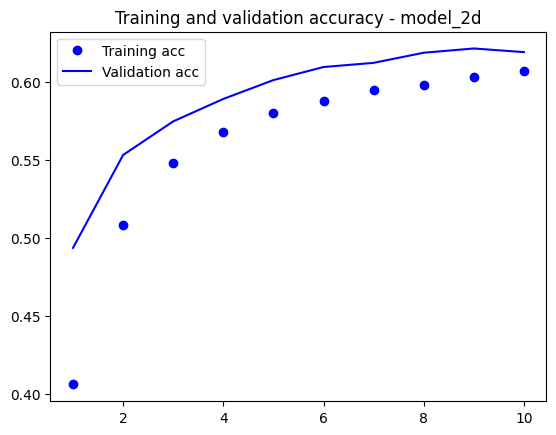

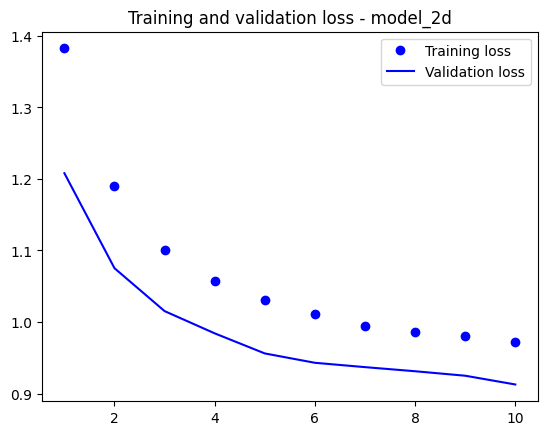

In [48]:
# Plot the Training and Validation Accuracy & Loss Scores
plotPerformance(history_2d, 'model_2d')

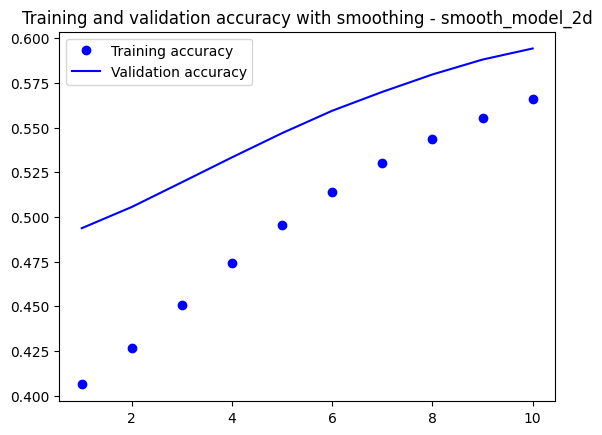

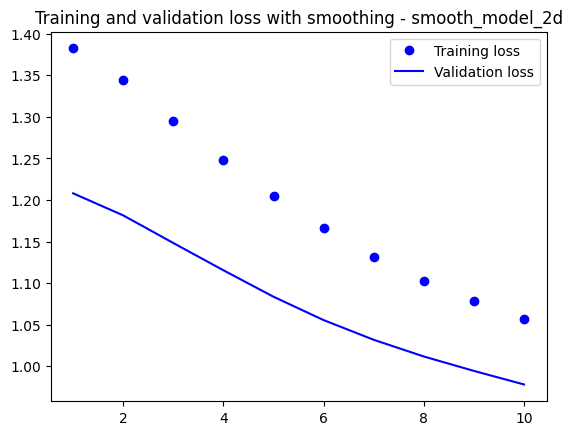

In [49]:
plotSmoothPerformance(history_2d, 'smooth_model_2d')

In [50]:
# Save the Model
model_2d.save('text_model_2d_conv1D.h5')

### Model #2 - 1D Conv Layer with NO Dropout, Early Stopping for Sentiment Analysis - # Epochs = 10

In [51]:
embedding_dim = 256
model_2e = getModel_2(tokenizer, embedding_dim, max_length, -1)
model_2e.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 153, 256)          20162304  
                                                                 
 conv1d_4 (Conv1D)           (None, 149, 128)          163968    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                                 
Total params: 20,330,565
Trainable params: 20,330,565
Non-trainable params: 0
__________________________________________

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
history_2e = model_2e.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/25
10349/10349 [==============================] - 128s 12ms/step - loss: 1.2301 - acc: 0.4817 - val_loss: 1.0320 - val_acc: 0.5683
Epoch 2/25
10349/10349 [==============================] - 130s 13ms/step - loss: 0.9405 - acc: 0.6075 - val_loss: 0.9270 - val_acc: 0.6153
Epoch 3/25
10349/10349 [==============================] - 134s 13ms/step - loss: 0.8551 - acc: 0.6405 - val_loss: 0.8750 - val_acc: 0.6358
Epoch 4/25
10349/10349 [==============================] - 131s 13ms/step - loss: 0.8143 - acc: 0.6570 - val_loss: 0.8828 - val_acc: 0.6345
Epoch 5/25
10349/10349 [==============================] - 131s 13ms/step - loss: 0.7913 - acc: 0.6659 - val_loss: 0.8625 - val_acc: 0.6471
Epoch 6/25
10349/10349 [==============================] - 131s 13ms/step - loss: 0.7781 - acc: 0.6725 - val_loss: 0.8528 - val_acc: 0.6534
Epoch 7/25
10349/10349 [==============================] - 127s 12ms/step - loss: 0.7689 - acc: 0.6762 - val_loss: 0.8594 - val_acc: 0.6572
Epoch 8/25
10349/10349 [===

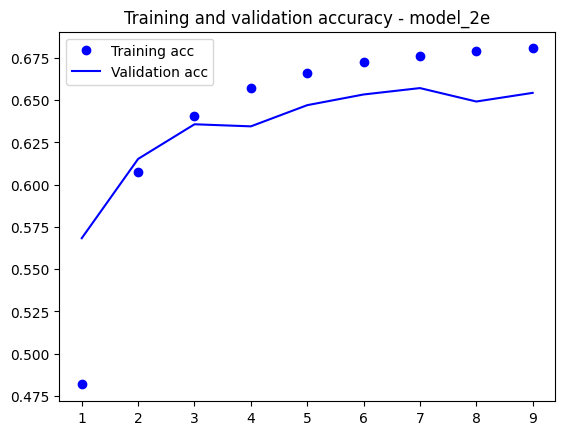

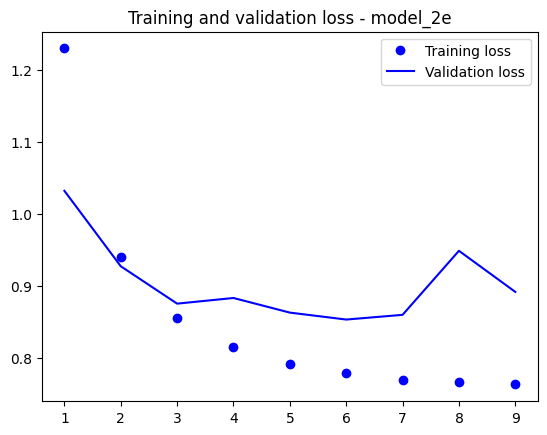

In [54]:
plotPerformance(history_2e, 'model_2e')

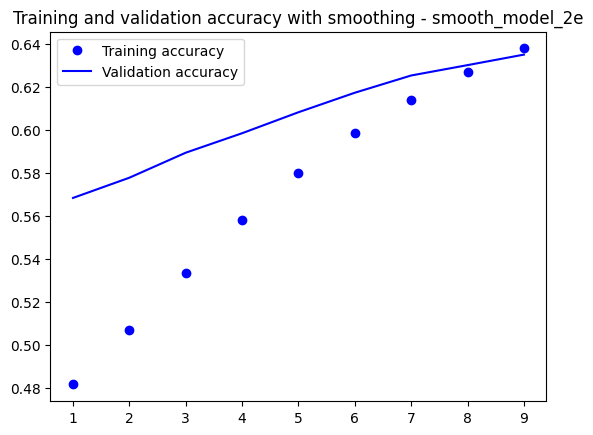

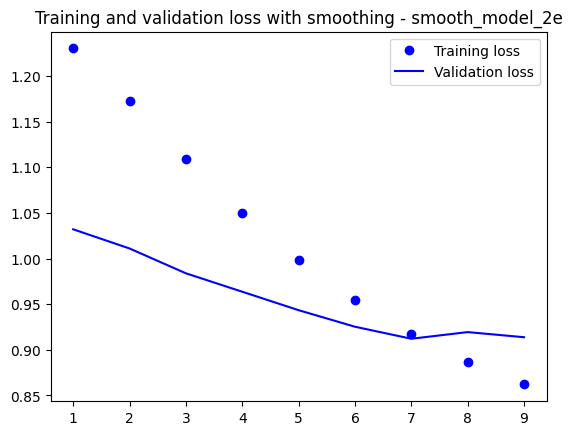

In [55]:
plotSmoothPerformance(history_2e, 'smooth_model_2e')

In [56]:
# Save the Model
model_2e.save('text_model_2e_conv1D.h5')

## Step 3 – Evaluate the Model using Testing Data

In [57]:
loss_1a, acc_1a = model_1a.evaluate(X_test, y_test, verbose=1)
loss_2a, acc_2a = model_2a.evaluate(X_test, y_test, verbose=1)
loss_2b, acc_2b = model_2b.evaluate(X_test, y_test, verbose=1)
loss_2c, acc_2c = model_2c.evaluate(X_test, y_test, verbose=1)
loss_2d, acc_2d = model_2d.evaluate(X_test, y_test, verbose=1)
loss_2e, acc_2e = model_2e.evaluate(X_test, y_test, verbose=1)

3234/3234 [==============================] - 10s 3ms/step - loss: 0.8468 - acc: 0.6552


In [58]:
# Example data: each experiment has a test loss and test accuracy
m2_experiment_results = [
    {"experiment": "Exp1", "test_loss": loss_1a, "test_acc": acc_1a},
    {"experiment": "Exp2", "test_loss": loss_2a, "test_acc": acc_2a},
    {"experiment": "Exp3", "test_loss": loss_2b, "test_acc": acc_2b},
    {"experiment": "Exp4", "test_loss": loss_2c, "test_acc": acc_2c},
    {"experiment": "Exp5", "test_loss": loss_2d, "test_acc": acc_2d},
    {"experiment": "Exp6", "test_loss": loss_2e, "test_acc": acc_2e}   
]

# Create a DataFrame
m2_df = pd.DataFrame(m2_experiment_results)

# Round the entire DataFrame to 2 decimal places
m2_df = m2_df.round({"test_loss": 2, "test_acc": 2})

display(m2_df)

# Optionally, if you want to find the best experiment
best_by_acc = m2_df.loc[m2_df['test_acc'].idxmax()]
best_by_loss = m2_df.loc[m2_df['test_loss'].idxmin()]
print("\nBest by accuracy:", best_by_acc, '\n')
print("\nBest by loss:", best_by_loss, '\n')

,experiment,test_loss,test_acc
0,Exp1,1.37,0.47
1,Exp2,1.09,0.64
2,Exp3,0.96,0.65
3,Exp4,0.93,0.64
4,Exp5,0.91,0.62
5,Exp6,0.85,0.66



Best by accuracy: experiment    Exp6
test_loss     0.85
test_acc      0.66
Name: 5, dtype: object 


Best by loss: experiment    Exp6
test_loss     0.85
test_acc      0.66
Name: 5, dtype: object 



In [59]:
# Save the Best Model
model_2e.save('text_model_best.h5')

## Step 4 – Use the Best Model to make prediction

In [61]:
import tensorflow as tf
best_model = tf.keras.models.load_model('text_model_best.h5')

In [ ]:
bad should be rate -1 if there is a negative scale
This is very bad
good
the best there is. Wonderful experience
can be improved
worst

In [62]:
ratings = [1, 2, 3, 4, 5]
# ratings = [0, 1, 2, 3, 4]
def doPredict(model, txt_reviews, max_length, ratings):
    # converts the user input into numeric tensor
    x_input = tokenizer.texts_to_sequences(txt_reviews)
    x_input = pad_sequences(x_input, maxlen=max_length)
    # show the model output using predict function; returns the proability values for each of the 5 ratings
    results = model.predict(x_input)
    results_df = pd.DataFrame(results, columns = ratings)
    result = ratings[np.argmax(results)]
    
    return results_df

In [63]:
# This function from IPython.display allows you to display a DataFrame nicely within a Jupyter Notebook.
# Use .style.highlight_max(axis=1) to highlight the maximum probability for each row.
# When you run predict_from_model, it will display each image alongside a nicely formatted DataFrame 
# showing the prediction probabilities, with the highest probability highlighted
def showResults(df):
    display(df.style.highlight_max(axis=1))

In [64]:
while True:
    # gets user input
    user_input = input("Enter something (type 'q' to quit): ")
    if user_input.lower() == 'q':
        print("Goodbye!")
        break
    else:
        text_input = np.array([user_input])
        result_df = doPredict(best_model, text_input, max_length, ratings)
        showResults(result_df)

Enter something (type 'q' to quit): i love the app
1/1 [==============================] - 0s 88ms/step


,1,2,3,4,5
0,0.010976,0.005898,0.024323,0.563616,0.395186


Enter something (type 'q' to quit): the App sucks
1/1 [==============================] - 0s 18ms/step


,1,2,3,4,5
0,0.998715,0.000457,0.000000,0.000000,0.000828


Enter something (type 'q' to quit): the app is quite nice
1/1 [==============================] - 0s 17ms/step


,1,2,3,4,5
0,0.002247,0.000000,0.089267,0.857364,0.051122


Enter something (type 'q' to quit): i recommend
1/1 [==============================] - 0s 18ms/step


,1,2,3,4,5
0,0.132717,0.523442,0.012675,0.028312,0.302854


Enter something (type 'q' to quit): best ever
1/1 [==============================] - 0s 18ms/step


,1,2,3,4,5
0,0.065537,0.013774,0.014199,0.115185,0.791305


Enter something (type 'q' to quit): q
Goodbye!


In [66]:
saveTrainingistory(history_1a, 'model_1a')
saveTrainingistory(history_2a, 'model_2a')
saveTrainingistory(history_2b, 'model_2b')
saveTrainingistory(history_2c, 'model_2c')
saveTrainingistory(history_2d, 'model_2d')
saveTrainingistory(history_2e, 'model_2e')

,loss,acc,val_loss,val_acc
0,1.230083,0.481749,1.031999,0.568340
1,0.940494,0.607521,0.927034,0.615268
2,0.855117,0.640544,0.874984,0.635767
3,0.814274,0.656984,0.882847,0.634535
4,0.791300,0.665887,0.862503,0.647074
5,0.778091,0.672524,0.852847,0.653403
6,0.768934,0.676248,0.859392,0.657184
7,0.766053,0.679144,0.948515,0.649236
8,0.762488,0.680630,0.891331,0.654358
